In [28]:
import os
import numpy as np

import torch
from fno.utils import get_num_params
from fno.pipeline import *
from fno.losses import SobolevLoss
from fno.datasets import BochnerDataset
from fno.visualizations import plot_contour_trajectory
from fno.sfno import SFNO
from torch.utils.data import DataLoader
torch.cuda.manual_seed_all(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [20]:
TRAIN_PATH = TEST_PATH = os.path.join(
    DATA_PATH, "McWilliams2d_fp32_64x64_N1152_v1e-3_T100.pt"
)

Ntrain = 1024
Ntest = 32

batch_size = 4

epochs = 15
learning_rate = 1e-2

n = 64
T = 10
fs = 'vorticity'

modes = 32
modes_t = 5
width = 10


model_name = (
    "sfno_v1e3_N"
    + str(Ntrain)
    + "_ep"
    + str(epochs)
    + "_m"
    + str(modes)
    + "_w"
    + str(width)
    + ".pt"
)
path_model = os.path.join(MODEL_PATH, model_name)
print(model_name)

sfno_v1e3_N1024_ep15_m32_w10.pt


In [21]:
train_dataset = BochnerDataset(datapath=TRAIN_PATH, 
                               n_samples=Ntrain,
                               steps=T)
test_dataset = BochnerDataset(datapath=TEST_PATH, 
                              n_samples=Ntest,
                              steps=T,
                              train=False)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width).to(device)

print(get_num_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    div_factor=1e4,
    final_div_factor=1e3,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
)

l2diff = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)

16433561


In [25]:
for ep in range(epochs):
    model.train()
    train_l2 = 0

    with tqdm(total=len(train_loader)) as pbar:
        for i, data in enumerate(train_loader):
            l2 = train_batch_ns(
                model,
                l2diff,
                data,
                optimizer,
                device,
            )
            train_l2 += l2.item()
            is_epoch_scheduler = any(s in str(scheduler.__class__) for s in EPOCH_SCHEDULERS)
            if not is_epoch_scheduler:
                scheduler.step()

            if i % 4 == 0:
                pbar.set_description(f"train rel L2: {l2.item():.4e}")
                pbar.update(4)
    test_l2_min = 1e4
    test_l2 = eval_epoch_ns(
        model, l2diff, test_loader, device,
    )

    if test_l2 < test_l2_min:
        torch.save(model.state_dict(), path_model)
        test_l2_min = test_l2

    print(
        f"\nEpoch {ep+1} | ",
        f"Train L2: {train_l2/len(train_loader):.5e} |",
        f"Test  L2: {test_l2:.5e}\n",
    )

  0%|          | 0/256 [00:00<?, ?it/s]

train rel L2: 2.5174e-01: 100%|██████████| 256/256 [00:09<00:00, 26.05it/s]



Epoch 1 |  Train L2: 2.92297e-01 | Test  L2: 2.45036e-01



train rel L2: 2.2074e-01: 100%|██████████| 256/256 [00:10<00:00, 25.36it/s]



Epoch 2 |  Train L2: 2.27361e-01 | Test  L2: 2.18510e-01



train rel L2: 1.7453e-01: 100%|██████████| 256/256 [00:09<00:00, 26.03it/s]



Epoch 3 |  Train L2: 2.02616e-01 | Test  L2: 1.79848e-01



train rel L2: 1.4927e-01: 100%|██████████| 256/256 [00:09<00:00, 25.91it/s]



Epoch 4 |  Train L2: 1.62186e-01 | Test  L2: 1.43784e-01



train rel L2: 1.2115e-01: 100%|██████████| 256/256 [00:09<00:00, 25.73it/s]



Epoch 5 |  Train L2: 1.32039e-01 | Test  L2: 1.21677e-01



train rel L2: 1.0548e-01: 100%|██████████| 256/256 [00:09<00:00, 25.79it/s]



Epoch 6 |  Train L2: 1.14403e-01 | Test  L2: 1.07952e-01



train rel L2: 1.0230e-01: 100%|██████████| 256/256 [00:09<00:00, 25.75it/s]



Epoch 7 |  Train L2: 1.02585e-01 | Test  L2: 9.80090e-02



train rel L2: 8.8601e-02: 100%|██████████| 256/256 [00:09<00:00, 25.72it/s]



Epoch 8 |  Train L2: 9.33245e-02 | Test  L2: 9.04114e-02



train rel L2: 7.4593e-02: 100%|██████████| 256/256 [00:09<00:00, 25.76it/s]



Epoch 9 |  Train L2: 8.60804e-02 | Test  L2: 8.26290e-02



train rel L2: 7.5160e-02: 100%|██████████| 256/256 [00:09<00:00, 25.77it/s]



Epoch 10 |  Train L2: 7.90551e-02 | Test  L2: 7.56049e-02



train rel L2: 7.3585e-02: 100%|██████████| 256/256 [00:09<00:00, 25.96it/s]



Epoch 11 |  Train L2: 7.36000e-02 | Test  L2: 7.18199e-02



train rel L2: 6.4453e-02: 100%|██████████| 256/256 [00:09<00:00, 25.71it/s]



Epoch 12 |  Train L2: 6.91318e-02 | Test  L2: 6.76147e-02



train rel L2: 7.0308e-02: 100%|██████████| 256/256 [00:09<00:00, 25.75it/s]



Epoch 13 |  Train L2: 6.58882e-02 | Test  L2: 6.43211e-02



train rel L2: 6.1059e-02: 100%|██████████| 256/256 [00:09<00:00, 25.77it/s]



Epoch 14 |  Train L2: 6.41427e-02 | Test  L2: 6.58233e-02



train rel L2: 6.3115e-02: 100%|██████████| 256/256 [00:10<00:00, 25.26it/s]



Epoch 15 |  Train L2: 6.32318e-02 | Test  L2: 6.45628e-02



In [26]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width).to(device)
model.load_state_dict(torch.load(path_model))
preds = []
gt_solns = []
test_l2_all = []
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
loss_func = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)

with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(test_loader):
        x, y = x[fs].to(device), y[fs].to(device)
        out, _ = model(x)

        preds.append(out)
        gt_solns.append(y)

        test_l2 = loss_func(out, y).item()
        test_l2_all.append(test_l2)

preds = torch.cat(preds, dim=0)
gt_solns = torch.cat(gt_solns, dim=0)
print(np.mean(test_l2_all))

0.06446205638349056


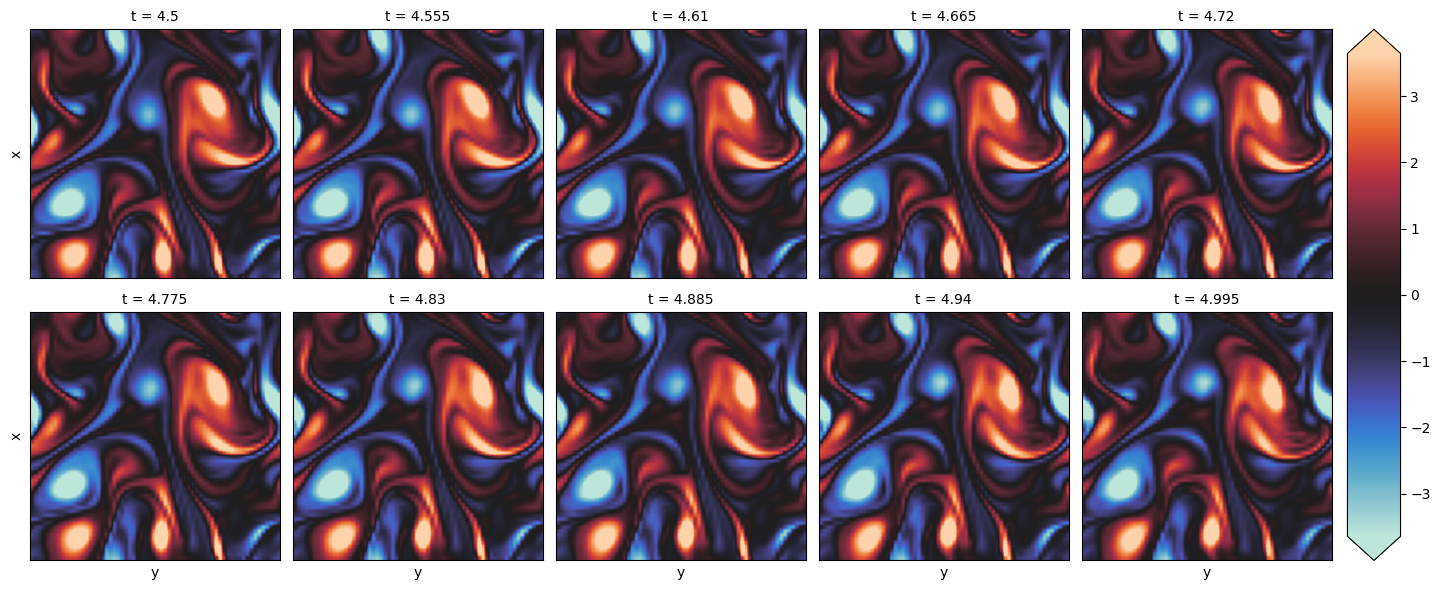

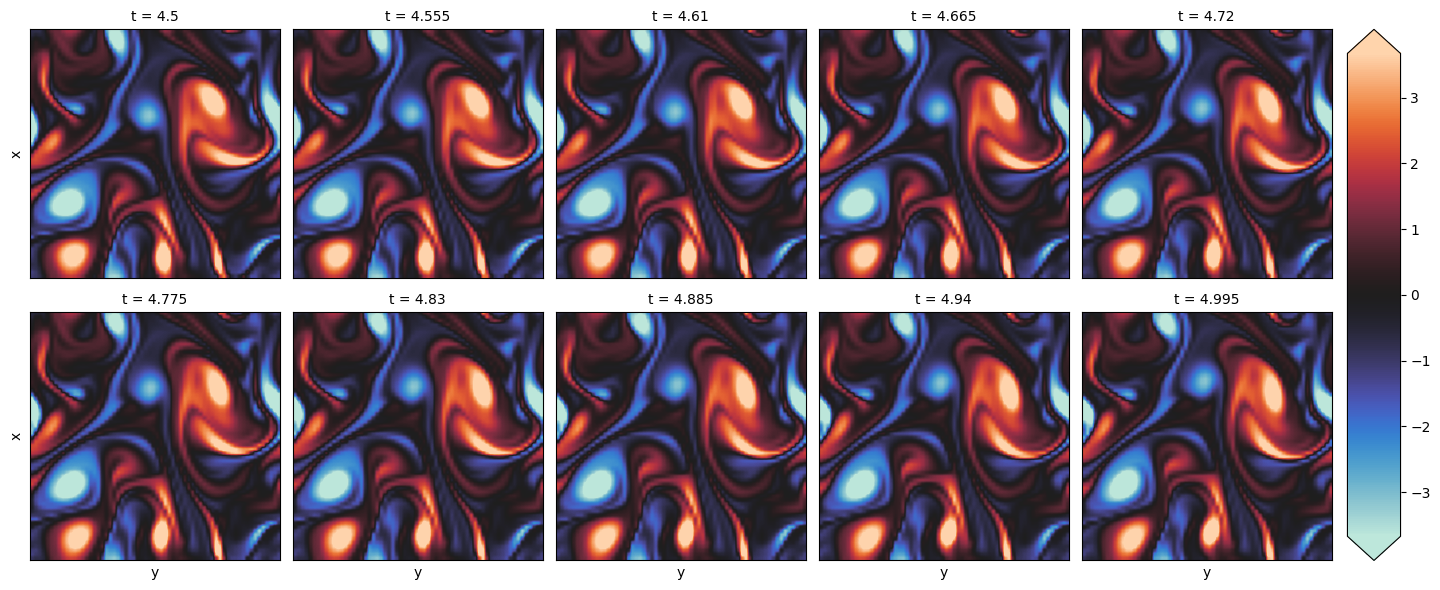

In [29]:
idx = np.random.randint(0, Ntest)
plot_contour_trajectory(preds[idx], num_snapshots=10, contourf=False, T_start=4.5, dt=5.5/100)
plot_contour_trajectory(gt_solns[idx], num_snapshots=10, contourf=False, T_start=4.5, dt=5.5/100)